In [1]:
import cv2
import dlib
import numpy as np
import os
import pandas as pd # Import pandas for CSV handling
# Removed 'math' as rotation logic is no longer needed

# Load detector and predictor
detector = dlib.get_frontal_face_detector()
# Adjusted path to be relative to the project folder, assuming 'models' is a direct child
# of the main project folder. The user's provided path was very specific,
# but a relative path is standard for project organization.
predictor = dlib.shape_predictor(
    "models/shape_predictor_68_face_landmarks.dat/shape_predictor_68_face_landmarks.dat"
)

# Define the root directories for input and output
root_input_dir = "archive_3"
root_output_dir = "processed_faces_newFinal3"

# Define the scaling factor for upscaling images (using the new scale from your friend's code)
scale_factor = 12

# Create the root output directory if it doesn't exist
os.makedirs(root_output_dir, exist_ok=True)

# List of emotion folders (assuming these are the names of your subfolders)
emotion_folders = ["anger", "contempt", "disgust", "happy", "sadness", "fear", "surprise"]

# List to store all landmark data for CSV export
all_landmarks_data = []

print("Starting facial landmark detection and processing for ALL photos...")
print("Output images will be split into '_with_photo' and '_without_photo' folders.")
print("A comprehensive CSV file with landmark coordinates will also be generated.")


for emotion in emotion_folders:
    input_emotion_path = os.path.join(root_input_dir, emotion)
    
    # Define the new output subfolders for each emotion
    # E.g., processed_faces/anger/anger_with_photo/
    output_with_photo_path = os.path.join(root_output_dir, emotion, f"{emotion}_with_photo")
    # E.g., processed_faces/anger/anger_without_photo/
    output_without_photo_path = os.path.join(root_output_dir, emotion, f"{emotion}_without_photo")

    # Create these new output subdirectories if they don't exist
    os.makedirs(output_with_photo_path, exist_ok=True)
    os.makedirs(output_without_photo_path, exist_ok=True)
    
    print(f"\nProcessing emotion: {emotion}...")

    # Iterate through each image in the emotion folder
    for filename in os.listdir(input_emotion_path):
        # Ensure we only process image files
        if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
            image_path = os.path.join(input_emotion_path, filename)
            image = cv2.imread(image_path)

            if image is None:
                print(f"Warning: Could not read image {image_path}. Skipping.")
                continue # Skip to the next file if image cannot be read
                
            print(f"  Processing file: {filename}")

            # Upscale the image (using the new scale_factor = 12)
            upscaled_image = cv2.resize(image, (0, 0), fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)
            gray = cv2.cvtColor(upscaled_image, cv2.COLOR_BGR2GRAY)

            # Detect faces in the upscaled grayscale image
            faces = detector(gray)

            if len(faces) > 0:
                # Process the first detected face (assuming one main face per photo)
                face = faces[0]
                landmarks = predictor(gray, face)

                # --- Collect landmark data for CSV ---
                landmark_row = {'emotion': emotion, 'filename': filename}
                for n in range(68):
                    x = landmarks.part(n).x
                    y = landmarks.part(n).y
                    landmark_row[f'landmark_{n}_x'] = x
                    landmark_row[f'landmark_{n}_y'] = y
                all_landmarks_data.append(landmark_row)
                # --- End of CSV data collection ---

                # --- Prepare images for both output types ---
                # 1. Image with original photo and landmarks (for _with_photo folder)
                drawn_image_with_photo = upscaled_image.copy() 

                # 2. Blank image for landmarks only (for _without_photo folder)
                # Create a black background image of the same size as the upscaled image
                drawn_image_without_photo = np.zeros(upscaled_image.shape, dtype=np.uint8) 

                # Get position of landmark 31 (index 30 in 0-based indexing) for quadrant lines
                nose_x = landmarks.part(30).x
                nose_y = landmarks.part(30).y

                # Draw quadrant lines centered at landmark 31 (only on image WITH photo)
                img_h, img_w = drawn_image_with_photo.shape[:2]
                cv2.line(drawn_image_with_photo, (nose_x, 0), (nose_x, img_h), (0, 255, 0), 1) # Green line
                cv2.line(drawn_image_with_photo, (0, nose_y), (img_w, nose_y), (0, 255, 0), 1) # Green line

                drawn_index = 1 # To label the landmark points
                seen = set()    # To avoid drawing same point multiple times if coordinates overlap

                for n in range(68):
                    x = landmarks.part(n).x
                    y = landmarks.part(n).y

                    if (x, y) in seen:
                        continue
                    seen.add((x, y))

                    # Define drawing properties for landmarks
                    circle_color = (0, 0, 255) # Red for circles (BGR format)
                    circle_radius =  2 # Larger radius for landmark 31 (nose)
                    fill_type = -1 # Fill the circle

                    text_font = cv2.FONT_HERSHEY_SIMPLEX
                    text_scale = 0.35
                    
                    # Offset for label (re-using your friend's logic for consistency)
                    offset_x, offset_y = -6, 10
                    if n in [37, 38, 39, 43, 44, 45]: # Upper eye points
                        offset_y = -10
                    elif n == 49: # Left mouth corner
                        offset_x = -20
                        offset_y = 6
                    elif n == 50: # Top lip center
                        offset_x = 0
                        offset_y = -8
                    elif n == 65: # Chin left
                        offset_x = -14
                        offset_y = 10
                    elif 48 <= n <= 54: # Upper lip
                        offset_y = -8
                    elif 55 <= n <= 59: # Lower lip center to right
                        offset_y = 10
                    elif 60 <= n <= 64: # Inner mouth top
                        offset_y = -8
                    elif 65 <= n <= 67: # Chin right
                        offset_y = 10
                    
                    # Draw on the image WITH photo (original background)
                    text_color_with_photo = (0, 0, 0) # Black text for visibility on varied backgrounds
                    cv2.circle(drawn_image_with_photo, (x, y), circle_radius, circle_color, fill_type)
                    cv2.putText(drawn_image_with_photo, str(drawn_index), (x + offset_x, y + offset_y),
                                text_font, text_scale, text_color_with_photo, 1, cv2.LINE_AA) # Changed thickness to 1 for consistency

                    # Draw on the image WITHOUT photo (black background)
                    # Use white color for landmarks/text for high contrast on black background
                    text_color_without_photo = (255, 255, 255) # White text
                    cv2.circle(drawn_image_without_photo, (x, y), circle_radius, text_color_without_photo, fill_type) 
                    cv2.putText(drawn_image_without_photo, str(drawn_index), (x + offset_x, y + offset_y),
                                text_font, text_scale, text_color_without_photo, 1, cv2.LINE_AA) # Changed thickness to 1

                    drawn_index += 1

                # Save the processed images to their respective folders
                output_image_path_with_photo = os.path.join(output_with_photo_path, filename)
                cv2.imwrite(output_image_path_with_photo, drawn_image_with_photo)
                
                output_image_path_without_photo = os.path.join(output_without_photo_path, filename)
                cv2.imwrite(output_image_path_without_photo, drawn_image_without_photo)
                
            else:
                print(f"  No face detected in {filename} from {emotion} folder.")
            
            # This 'break' statement was for testing only and has been REMOVED.
            # The script will now process all images found in each folder.

print("\nAll emotion folders and photos processed successfully!")

# --- Save all collected landmark data to a single CSV file ---
if all_landmarks_data:
    df = pd.DataFrame(all_landmarks_data)
    csv_output_path = os.path.join(root_output_dir, "facial_landmarks_data.csv")
    df.to_csv(csv_output_path, index=False)
    print(f"All facial landmark coordinates saved to: {csv_output_path}")
else:
    print("No facial landmark data was collected (no faces detected or no images processed).")



Starting facial landmark detection and processing for ALL photos...
Output images will be split into '_with_photo' and '_without_photo' folders.
A comprehensive CSV file with landmark coordinates will also be generated.

Processing emotion: anger...
  Processing file: S010_004_00000017.png
  Processing file: S010_004_00000018.png
  Processing file: S010_004_00000019.png
  Processing file: S011_004_00000019.png
  Processing file: S011_004_00000020.png
  Processing file: S011_004_00000021.png
  Processing file: S014_003_00000028.png
  Processing file: S014_003_00000029.png
  Processing file: S014_003_00000030.png
  Processing file: S022_005_00000030.png
  Processing file: S022_005_00000031.png
  Processing file: S022_005_00000032.png
  Processing file: S026_003_00000013.png
  Processing file: S026_003_00000014.png
  Processing file: S026_003_00000015.png
  Processing file: S028_001_00000022.png
  Processing file: S028_001_00000023.png
  Processing file: S028_001_00000024.png
  Processing

In [2]:
import cv2
import dlib
import numpy as np
import os
import pandas as pd
# Removed 'math' as rotation logic is no longer needed

# Load detector and predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(
    "models/shape_predictor_68_face_landmarks.dat/shape_predictor_68_face_landmarks.dat"
)

# Define the root directories for input and output
root_input_dir = "archive_3"
root_output_dir = "processed_faces_newFinal3"

# Define the scaling factor for upscaling images
scale_factor = 12

# Create the root output directory if it doesn't exist
os.makedirs(root_output_dir, exist_ok=True)

# List of emotion folders
emotion_folders = ["anger", "contempt", "disgust", "happy", "sadness", "fear", "surprise"]

# List to store all landmark data for CSV export
all_landmarks_data = []

# List to store the 2D valence-arousal vectors for each image
all_valence_arousal_vectors = []

print("Starting facial landmark detection and processing for ALL photos...")
print("Output images will be split into '_with_photo' and '_without_photo' folders.")
print("A comprehensive CSV file with landmark coordinates will also be generated.")
print("2D valence-arousal vectors for each image will also be generated.")

# Helper function to calculate distance between two points
def calculate_distance(p1, p2):
    return np.sqrt((p1.x - p2.x)**2 + (p1.y - p2.y)**2)

# Function to calculate valence and arousal based on simplified heuristics
def calculate_valence_arousal(landmarks, part_name, reference_distance):
    valence = 0.0
    arousal = 0.0

    # These are very simplified heuristics.
    # In a real application, you'd need more sophisticated models,
    # possibly based on Action Units (AUs) and psychological studies.

    if part_name == "left_eyebrow":
        # Points: 17-21 (left eyebrow)
        # Higher eyebrow (smaller y values for same x) might indicate surprise (high arousal, neutral/positive valence)
        # Lowered eyebrow (larger y) might indicate anger/sadness (negative valence, high/medium arousal)
        
        # Example feature: vertical distance from eyebrow to eye
        # Using landmark 19 (top of left eyebrow) and landmark 37 (inner corner of left eye)
        eyebrow_y_avg = np.mean([landmarks.part(i).y for i in range(17, 22)])
        eye_y_avg = np.mean([landmarks.part(i).y for i in range(36, 42)])
        vertical_dist = (eye_y_avg - eyebrow_y_avg) / reference_distance

        if vertical_dist < 0.1: # Heuristic for raised eyebrow (surprise)
            valence = 0.3 # Slightly positive for surprise
            arousal = 0.8 # High arousal
        elif vertical_dist > 0.15: # Heuristic for lowered/furrowed eyebrow (anger/sadness)
            valence = -0.6 # Negative
            arousal = 0.7 # High arousal
        else: # Neutral
            valence = 0.0
            arousal = 0.2

    elif part_name == "right_eyebrow":
        # Points: 22-26 (right eyebrow)
        eyebrow_y_avg = np.mean([landmarks.part(i).y for i in range(22, 27)])
        eye_y_avg = np.mean([landmarks.part(i).y for i in range(42, 48)])
        vertical_dist = (eye_y_avg - eyebrow_y_avg) / reference_distance

        if vertical_dist < 0.1: # Heuristic for raised eyebrow (surprise)
            valence = 0.3
            arousal = 0.8
        elif vertical_dist > 0.15: # Heuristic for lowered/furrowed eyebrow (anger/sadness)
            valence = -0.6
            arousal = 0.7
        else: # Neutral
            valence = 0.0
            arousal = 0.2

    elif part_name == "left_eye":
        # Points: 36-41 (left eye)
        # Eye openness: Ratio of vertical to horizontal distance. Wider eyes (more open) can indicate surprise/fear (high arousal).
        # Narrowed eyes can indicate happiness (positive valence, medium arousal) or disgust/contempt (negative valence, medium arousal).
        
        # Eye aspect ratio (EAR)
        p1 = landmarks.part(36)
        p2 = landmarks.part(37)
        p3 = landmarks.part(38)
        p4 = landmarks.part(39)
        p5 = landmarks.part(40)
        p6 = landmarks.part(41)

        A = calculate_distance(p2, p6)
        B = calculate_distance(p3, p5)
        C = calculate_distance(p1, p4) # Horizontal distance
        
        if C == 0: C = 1e-6 # Avoid division by zero
        ear = (A + B) / (2.0 * C)

        if ear > 0.28: # Wide open eyes (surprise, fear) - heuristic value
            valence = 0.1 # Can be neutral to slightly negative/positive
            arousal = 0.9 # High arousal
        elif ear < 0.2: # Squinted eyes (happy, disgust) - heuristic value
            valence = 0.5 # Could be positive for happy
            arousal = 0.5 # Medium arousal
        else: # Neutral
            valence = 0.0
            arousal = 0.2

    elif part_name == "right_eye":
        # Points: 42-47 (right eye)
        p1 = landmarks.part(42)
        p2 = landmarks.part(43)
        p3 = landmarks.part(44)
        p4 = landmarks.part(45)
        p5 = landmarks.part(46)
        p6 = landmarks.part(47)

        A = calculate_distance(p2, p6)
        B = calculate_distance(p3, p5)
        C = calculate_distance(p1, p4)
        
        if C == 0: C = 1e-6
        ear = (A + B) / (2.0 * C)

        if ear > 0.28: # Wide open eyes
            valence = 0.1
            arousal = 0.9
        elif ear < 0.2: # Squinted eyes
            valence = 0.5
            arousal = 0.5
        else: # Neutral
            valence = 0.0
            arousal = 0.2

    elif part_name == "nose":
        # Points: 27-35 (nose)
        # Flared nostrils (wider nose) might indicate anger/disgust (negative valence, high arousal).
        # Nose wrinkle could indicate disgust.
        # This is harder to capture with simple distances without more advanced feature engineering.
        
        # Example: width of nose bridge (29, 31) relative to face width
        nose_width = calculate_distance(landmarks.part(31), landmarks.part(35)) # Base of nose (approx)
        
        # Consider a general mid-nose point and its relation to surrounding features.
        # For simplicity, we'll use a relatively neutral valence/arousal for nose,
        # as its direct contribution to V/A is often subtle without specific muscle movements.
        
        # If the nose bridge is significantly wider, indicating potential flaring (e.g., landmark 35 is far from 31)
        # Using 31 (nose tip) and 35 (right nostril corner)
        # A more robust approach would involve checking distances between 31, 32, 33, 34, 35
        # For now, let's keep it simple:
        
        # Example: Nose wrinkle (related to disgust) - difficult to quantify directly from landmarks
        # without looking at skin deformation. Let's simplify.
        
        # For a simple heuristic, the nose itself doesn't inherently change valence/arousal much,
        # unless coupled with other expressions. We'll set it to a low baseline.
        valence = 0.0
        arousal = 0.1
        
        # However, if we were to detect nostril flaring (e.g., in anger/disgust)
        # This often involves points 31, 32, 33, 34, 35
        # The horizontal distance between landmarks 31 and 35 (base of nostrils)
        
        # Let's try to infer some level of arousal from the nose
        # For example, if nose tip (30) is very high relative to base, could indicate tension/arousal
        # This is speculative without proper studies.

        # Let's consider the vertical distance between nose bridge (27) and nose tip (30)
        vertical_nose_dist = (landmarks.part(30).y - landmarks.part(27).y) / reference_distance
        if vertical_nose_dist > 0.1: # Longer nose might indicate some tension (e.g. disgust) - weak heuristic
            valence = -0.2
            arousal = 0.3

    elif part_name == "lips":
        # Points: 48-67 (mouth)
        # Mouth openness (arousal), smile width (valence), lip corner depression (valence).
        
        # Mouth aspect ratio (MAR) for openness/arousal
        p1 = landmarks.part(61) # Inner top lip
        p2 = landmarks.part(67) # Inner bottom lip
        vertical_mouth_dist = calculate_distance(p1, p2)

        p3 = landmarks.part(48) # Left mouth corner
        p4 = landmarks.part(54) # Right mouth corner
        horizontal_mouth_dist = calculate_distance(p3, p4)
        
        if horizontal_mouth_dist == 0: horizontal_mouth_dist = 1e-6
        mar = vertical_mouth_dist / horizontal_mouth_dist

        # Smile (positive valence)
        # Distance between mouth corners (48 and 54) relative to overall face width
        # And vertical position of corners (48, 54) relative to mouth center (51, 57)
        # A simple smile detector: corners go up.
        
        # Vertical position of mouth corners relative to the central point of the mouth
        mouth_center_y = (landmarks.part(51).y + landmarks.part(57).y) / 2
        
        # Average y-coordinate of mouth corners
        avg_corner_y = (landmarks.part(48).y + landmarks.part(54).y) / 2
        
        # If corners are significantly higher than mouth center (negative diff)
        smile_indicator = (mouth_center_y - avg_corner_y) / reference_distance
        
        if smile_indicator > 0.02 and mar < 0.2: # Heuristic for smile (corners up, mouth not wide open)
            valence = 0.9 # High positive valence
            arousal = 0.6 # Medium arousal
        elif mar > 0.4: # Wide open mouth (surprise, fear, shouting) - heuristic value
            valence = -0.1 # Can be negative or neutral
            arousal = 0.9 # High arousal
        elif smile_indicator < -0.01 and mar < 0.1: # Frowning (corners down) - heuristic
            valence = -0.7 # Negative valence
            arousal = 0.5 # Medium arousal
        else: # Neutral
            valence = 0.0
            arousal = 0.2
            
    # Clamp values to [-1, 1] range for consistency
    valence = np.clip(valence, -1.0, 1.0)
    arousal = np.clip(arousal, -1.0, 1.0)

    return valence, arousal


for emotion in emotion_folders:
    input_emotion_path = os.path.join(root_input_dir, emotion)
    
    output_with_photo_path = os.path.join(root_output_dir, emotion, f"{emotion}_with_photo")
    output_without_photo_path = os.path.join(root_output_dir, emotion, f"{emotion}_without_photo")

    os.makedirs(output_with_photo_path, exist_ok=True)
    os.makedirs(output_without_photo_path, exist_ok=True)
    
    print(f"\nProcessing emotion: {emotion}...")

    for filename in os.listdir(input_emotion_path):
        if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
            image_path = os.path.join(input_emotion_path, filename)
            image = cv2.imread(image_path)

            if image is None:
                print(f"Warning: Could not read image {image_path}. Skipping.")
                continue
                
            print(f"   Processing file: {filename}")

            upscaled_image = cv2.resize(image, (0, 0), fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)
            gray = cv2.cvtColor(upscaled_image, cv2.COLOR_BGR2GRAY)

            faces = detector(gray)

            if len(faces) > 0:
                face = faces[0]
                landmarks = predictor(gray, face)

                # --- Calculate reference distance for normalization ---
                # Inter-eye distance (between points 39 and 42 for inner corners) or 36 and 45 for outer corners
                # Using distance between outer eye corners (36 and 45) for robustness
                reference_distance = calculate_distance(landmarks.part(36), landmarks.part(45))
                if reference_distance == 0: reference_distance = 1.0 # Avoid division by zero

                # --- Create the 2D Valence/Arousal Vector ---
                # Initialize an empty list to store (valence, arousal) for each part
                valence_arousal_parts = []
                
                parts = ["left_eyebrow", "right_eyebrow", "left_eye", "right_eye", "nose", "lips"]
                
                for part in parts:
                    valence, arousal = calculate_valence_arousal(landmarks, part, reference_distance)
                    valence_arousal_parts.append([valence, arousal])
                
                # Convert the list to a NumPy array (6 rows, 2 columns)
                image_valence_arousal_vector = np.array(valence_arousal_parts)
                
                # Store the vector along with its emotion and filename
                all_valence_arousal_vectors.append({
                    'emotion': emotion,
                    'filename': filename,
                    'valence_arousal_vector': image_valence_arousal_vector
                })
                # --- End of 2D Valence/Arousal Vector creation ---


                # --- Collect landmark data for CSV ---
                landmark_row = {'emotion': emotion, 'filename': filename}
                for n in range(68):
                    x = landmarks.part(n).x
                    y = landmarks.part(n).y
                    landmark_row[f'landmark_{n}_x'] = x
                    landmark_row[f'landmark_{n}_y'] = y
                all_landmarks_data.append(landmark_row)
                # --- End of CSV data collection ---

                # --- Prepare images for both output types (existing drawing logic) ---
                drawn_image_with_photo = upscaled_image.copy() 
                drawn_image_without_photo = np.zeros(upscaled_image.shape, dtype=np.uint8) 

                nose_x = landmarks.part(30).x
                nose_y = landmarks.part(30).y

                img_h, img_w = drawn_image_with_photo.shape[:2]
                cv2.line(drawn_image_with_photo, (nose_x, 0), (nose_x, img_h), (0, 255, 0), 1)
                cv2.line(drawn_image_with_photo, (0, nose_y), (img_w, nose_y), (0, 255, 0), 1)

                drawn_index = 1
                seen = set()

                for n in range(68):
                    x = landmarks.part(n).x
                    y = landmarks.part(n).y

                    if (x, y) in seen:
                        continue
                    seen.add((x, y))

                    circle_color = (0, 0, 255)
                    circle_radius = 2
                    fill_type = -1

                    text_font = cv2.FONT_HERSHEY_SIMPLEX
                    text_scale = 0.35
                    
                    offset_x, offset_y = -6, 10
                    if n in [37, 38, 39, 43, 44, 45]:
                        offset_y = -10
                    elif n == 49:
                        offset_x = -20
                        offset_y = 6
                    elif n == 50:
                        offset_x = 0
                        offset_y = -8
                    elif n == 65:
                        offset_x = -14
                        offset_y = 10
                    elif 48 <= n <= 54:
                        offset_y = -8
                    elif 55 <= n <= 59:
                        offset_y = 10
                    elif 60 <= n <= 64:
                        offset_y = -8
                    elif 65 <= n <= 67:
                        offset_y = 10
                    
                    text_color_with_photo = (0, 0, 0)
                    cv2.circle(drawn_image_with_photo, (x, y), circle_radius, circle_color, fill_type)
                    cv2.putText(drawn_image_with_photo, str(drawn_index), (x + offset_x, y + offset_y),
                                 text_font, text_scale, text_color_with_photo, 1, cv2.LINE_AA)

                    text_color_without_photo = (255, 255, 255)
                    cv2.circle(drawn_image_without_photo, (x, y), circle_radius, text_color_without_photo, fill_type) 
                    cv2.putText(drawn_image_without_photo, str(drawn_index), (x + offset_x, y + offset_y),
                                 text_font, text_scale, text_color_without_photo, 1, cv2.LINE_AA)

                    drawn_index += 1

                output_image_path_with_photo = os.path.join(output_with_photo_path, filename)
                cv2.imwrite(output_image_path_with_photo, drawn_image_with_photo)
                
                output_image_path_without_photo = os.path.join(output_without_photo_path, filename)
                cv2.imwrite(output_image_path_without_photo, drawn_image_without_photo)
                
            else:
                print(f"   No face detected in {filename} from {emotion} folder.")
            
print("\nAll emotion folders and photos processed successfully!")

# --- Save all collected landmark data to a single CSV file ---
if all_landmarks_data:
    df = pd.DataFrame(all_landmarks_data)
    csv_output_path = os.path.join(root_output_dir, "facial_landmarks_data.csv")
    df.to_csv(csv_output_path, index=False)
    print(f"All facial landmark coordinates saved to: {csv_output_path}")
else:
    print("No facial landmark data was collected (no faces detected or no images processed).")

# --- Process and Save the 2D Valence/Arousal Vectors ---
if all_valence_arousal_vectors:
    # Create a DataFrame for the valence/arousal vectors
    # Each row will represent an image, with columns for emotion, filename,
    # and then 12 columns for valence/arousal of each part (e.g., 'le_v', 'le_a', 're_v', 're_a', ...)
    
    vector_data_for_df = []
    for item in all_valence_arousal_vectors:
        row = {'emotion': item['emotion'], 'filename': item['filename']}
        
        # Flatten the 6x2 vector into 12 columns
        parts_list = ["left_eyebrow", "right_eyebrow", "left_eye", "right_eye", "nose", "lips"]
        for i, part_vector in enumerate(item['valence_arousal_vector']):
            part_name_short = parts_list[i][:2] if parts_list[i] != "lips" else "li" # e.g., 'le', 're', 'no', 'li'
            row[f'{part_name_short}_v'] = part_vector[0] # Valence
            row[f'{part_name_short}_a'] = part_vector[1] # Arousal
        vector_data_for_df.append(row)

    df_valence_arousal = pd.DataFrame(vector_data_for_df)
    csv_valence_arousal_path = os.path.join(root_output_dir, "valence_arousal_vectors.csv")
    df_valence_arousal.to_csv(csv_valence_arousal_path, index=False)
    print(f"All 2D valence-arousal vectors saved to: {csv_valence_arousal_path}")
else:
    print("No valence-arousal vectors were generated.")

Starting facial landmark detection and processing for ALL photos...
Output images will be split into '_with_photo' and '_without_photo' folders.
A comprehensive CSV file with landmark coordinates will also be generated.
2D valence-arousal vectors for each image will also be generated.

Processing emotion: anger...
   Processing file: S010_004_00000017.png
   Processing file: S010_004_00000018.png
   Processing file: S010_004_00000019.png
   Processing file: S011_004_00000019.png
   Processing file: S011_004_00000020.png
   Processing file: S011_004_00000021.png
   Processing file: S014_003_00000028.png
   Processing file: S014_003_00000029.png
   Processing file: S014_003_00000030.png
   Processing file: S022_005_00000030.png
   Processing file: S022_005_00000031.png
   Processing file: S022_005_00000032.png
   Processing file: S026_003_00000013.png
   Processing file: S026_003_00000014.png
   Processing file: S026_003_00000015.png
   Processing file: S028_001_00000022.png
   Processin

Attempting to load data from: processed_faces_newFinal3\valence_arousal_vectors.csv
Data loaded successfully.
DataFrame head:
  emotion               filename  le_v  le_a  ri_v  ri_a  no_v  no_a  li_v  \
0   anger  S010_004_00000017.png   0.0   0.2   0.0   0.2  -0.2   0.3   0.9   
1   anger  S010_004_00000018.png   0.0   0.2   0.0   0.2  -0.2   0.3   0.9   
2   anger  S010_004_00000019.png   0.0   0.2   0.0   0.2  -0.2   0.3   0.9   
3   anger  S011_004_00000019.png   0.1   0.9   0.1   0.9  -0.2   0.3   0.0   
4   anger  S011_004_00000020.png   0.1   0.9   0.1   0.9  -0.2   0.3   0.0   

   li_a  
0   0.6  
1   0.6  
2   0.6  
3   0.2  
4   0.2  

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   emotion   980 non-null    object 
 1   filename  980 non-null    object 
 2   le_v      980 non-null    float64
 3   le_a      980 non-null 

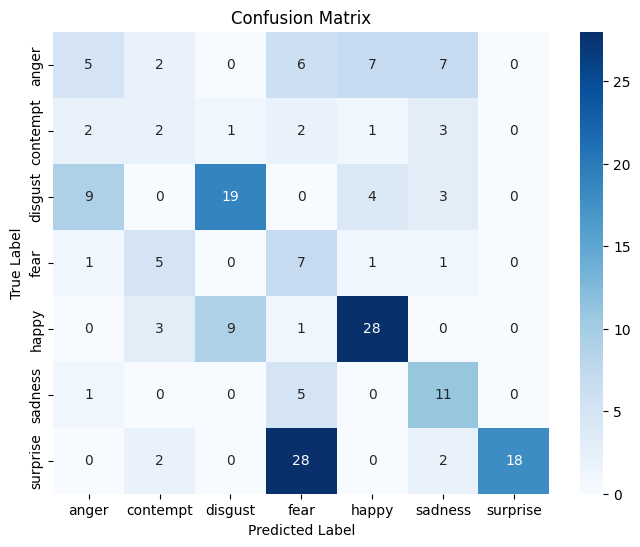


Model training and evaluation complete using valence and arousal vectors.
The model has been trained to classify emotions based purely on the calculated valence and arousal for facial parts, without seeing the actual images.


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Define the path to your generated CSV file
# This assumes the script is run from the same directory where 'processed_faces_newFinal3' is located,
# or you can adjust the path as needed.
root_output_dir = "processed_faces_newFinal3"
csv_valence_arousal_path = os.path.join(root_output_dir, "valence_arousal_vectors.csv")

print(f"Attempting to load data from: {csv_valence_arousal_path}")

try:
    # Load the 2D valence/arousal vectors data
    df = pd.read_csv(csv_valence_arousal_path)
    print("Data loaded successfully.")
    print("DataFrame head:")
    print(df.head())
    print("\nDataFrame info:")
    df.info()

except FileNotFoundError:
    print(f"Error: The file '{csv_valence_arousal_path}' was not found.")
    print("Please ensure the previous script ran successfully and generated this CSV.")
    exit() # Exit if the file isn't found

# --- Prepare Features (X) and Labels (y) ---

# The feature columns are all columns except 'emotion' and 'filename'
feature_columns = [col for col in df.columns if col not in ['emotion', 'filename']]
X = df[feature_columns]
y = df['emotion']

print(f"\nFeatures (X) shape: {X.shape}")
print(f"Labels (y) shape: {y.shape}")
print(f"Number of samples: {len(X)}")

# Check for any missing values in features
if X.isnull().sum().sum() > 0:
    print("Warning: Missing values found in features. Consider imputation if this is unexpected.")
    # You might want to handle these, e.g., X.fillna(X.mean(), inplace=True)
    # For now, we'll proceed, but be aware it might cause issues with some models.

# Check for unique emotion labels
print("\nUnique emotion labels in the dataset:")
print(y.value_counts())

# --- Split the Data into Training and Testing Sets ---
print("\nSplitting data into 80% training and 20% testing...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# random_state for reproducibility
# stratify=y ensures that the proportion of classes in the training and test sets is the same as in the input dataset

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# --- Choose and Train a Model (Random Forest Classifier) ---
print("\nTraining a Random Forest Classifier model...")
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
# n_estimators: number of trees in the forest
# class_weight='balanced': important if your emotion classes are imbalanced
model.fit(X_train, y_train)
print("Model training complete.")

# --- Evaluate the Model ---
print("\nEvaluating the model on the test set...")
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Optional: Visualize the Confusion Matrix for better understanding
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("\nModel training and evaluation complete using valence and arousal vectors.")
print("The model has been trained to classify emotions based purely on the calculated valence and arousal for facial parts, without seeing the actual images.")

Attempting to load data from: processed_faces_newFinal3\valence_arousal_vectors.csv
Data loaded successfully.
DataFrame head:
  emotion               filename  le_v  le_a  ri_v  ri_a  no_v  no_a  li_v  \
0   anger  S010_004_00000017.png   0.0   0.2   0.0   0.2  -0.2   0.3   0.9   
1   anger  S010_004_00000018.png   0.0   0.2   0.0   0.2  -0.2   0.3   0.9   
2   anger  S010_004_00000019.png   0.0   0.2   0.0   0.2  -0.2   0.3   0.9   
3   anger  S011_004_00000019.png   0.1   0.9   0.1   0.9  -0.2   0.3   0.0   
4   anger  S011_004_00000020.png   0.1   0.9   0.1   0.9  -0.2   0.3   0.0   

   li_a  
0   0.6  
1   0.6  
2   0.6  
3   0.2  
4   0.2  

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   emotion   980 non-null    object 
 1   filename  980 non-null    object 
 2   le_v      980 non-null    float64
 3   le_a      980 non-null 

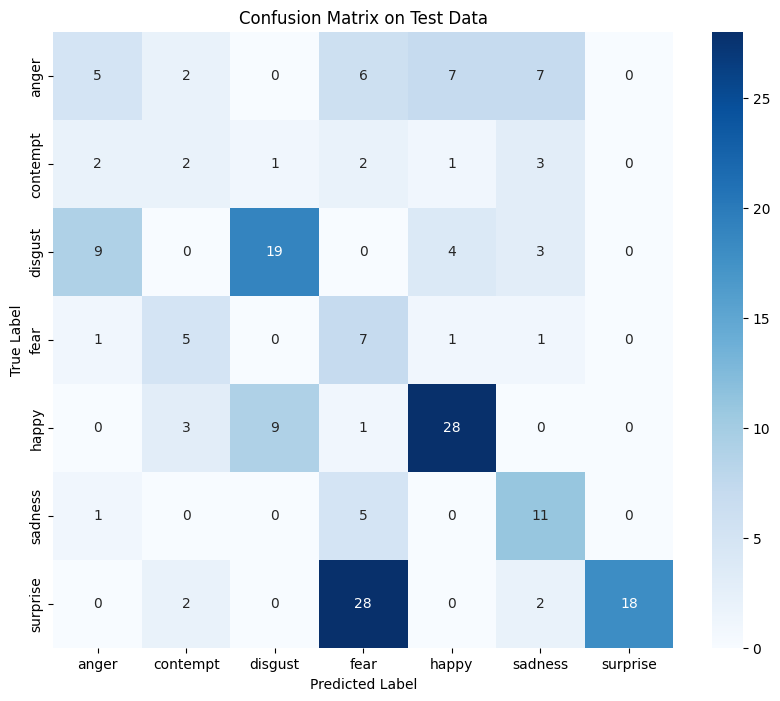


Model training and evaluation complete using valence and arousal vectors.
The model has been trained to classify emotions based purely on the calculated valence and arousal for facial parts, without seeing the actual images.


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Define the path to your generated CSV file
root_output_dir = "processed_faces_newFinal3"
csv_valence_arousal_path = os.path.join(root_output_dir, "valence_arousal_vectors.csv")

print(f"Attempting to load data from: {csv_valence_arousal_path}")

try:
    # Load the 2D valence/arousal vectors data
    df = pd.read_csv(csv_valence_arousal_path)
    print("Data loaded successfully.")
    print("DataFrame head:")
    print(df.head())
    print("\nDataFrame info:")
    df.info()

except FileNotFoundError:
    print(f"Error: The file '{csv_valence_arousal_path}' was not found.")
    print("Please ensure the previous script ran successfully and generated this CSV.")
    exit() # Exit if the file isn't found

# --- Prepare Features (X) and Labels (y) ---

# The feature columns are all columns except 'emotion' and 'filename'
feature_columns = [col for col in df.columns if col not in ['emotion', 'filename']]
X = df[feature_columns]
y = df['emotion']

print(f"\nFeatures (X) shape: {X.shape}")
print(f"Labels (y) shape: {y.shape}")
print(f"Number of samples: {len(X)}")

# Check for any missing values in features
if X.isnull().sum().sum() > 0:
    print("Warning: Missing values found in features. Consider imputation if this is unexpected.")
    # For now, we'll proceed, but be aware it might cause issues with some models.

# Check for unique emotion labels
print("\nUnique emotion labels in the dataset:")
print(y.value_counts())

# --- Split the Data into Training and Testing Sets ---
print("\nSplitting data into 80% training and 20% testing...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# --- Choose and Train a Model (Random Forest Classifier) ---
print("\nTraining a Random Forest Classifier model...")
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)
print("Model training complete.")

# --- Evaluate the Model on Training Data ---
print("\nEvaluating the model on the TRAINING set...")
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))


# --- Evaluate the Model on Testing Data ---
print("\nEvaluating the model on the TEST set...")
y_test_pred = model.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))

print("\nTest Confusion Matrix:")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)


print(f"Training Accuracy: {train_accuracy:.4f}")
# ...
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# Optional: Visualize the Confusion Matrix for better understanding
plt.figure(figsize=(10, 8)) # Increased figure size for better readability
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Data')
plt.show()

print("\nModel training and evaluation complete using valence and arousal vectors.")
print("The model has been trained to classify emotions based purely on the calculated valence and arousal for facial parts, without seeing the actual images.")

Attempting to load data from: processed_faces_newFinal3\valence_arousal_vectors.csv
Data loaded successfully.
DataFrame head:
  emotion               filename  le_v  le_a  ri_v  ri_a  no_v  no_a  li_v  \
0   anger  S010_004_00000017.png   0.0   0.2   0.0   0.2  -0.2   0.3   0.9   
1   anger  S010_004_00000018.png   0.0   0.2   0.0   0.2  -0.2   0.3   0.9   
2   anger  S010_004_00000019.png   0.0   0.2   0.0   0.2  -0.2   0.3   0.9   
3   anger  S011_004_00000019.png   0.1   0.9   0.1   0.9  -0.2   0.3   0.0   
4   anger  S011_004_00000020.png   0.1   0.9   0.1   0.9  -0.2   0.3   0.0   

   li_a  
0   0.6  
1   0.6  
2   0.6  
3   0.2  
4   0.2  

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   emotion   980 non-null    object 
 1   filename  980 non-null    object 
 2   le_v      980 non-null    float64
 3   le_a      980 non-null 

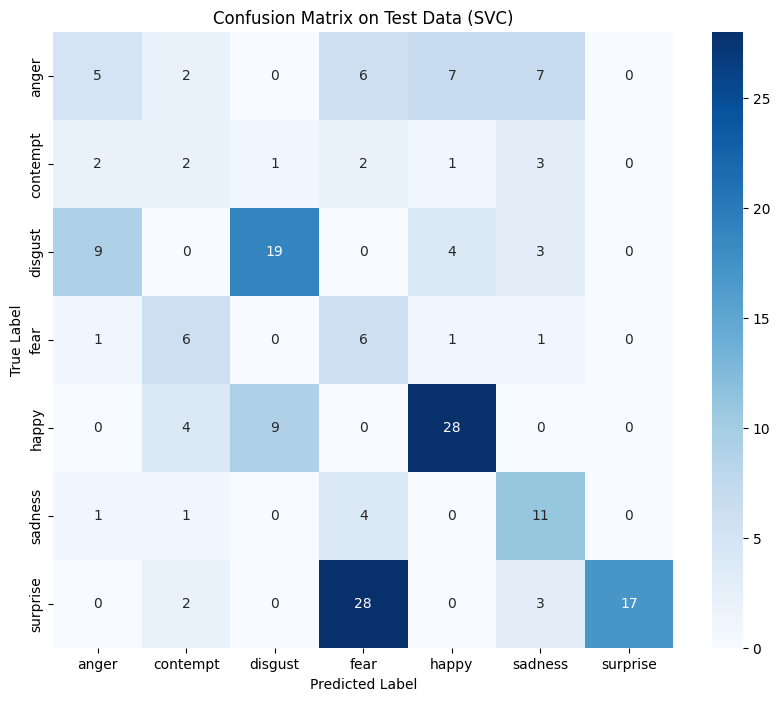


Model training and evaluation complete using valence and arousal vectors with SVC.
The model has been trained to classify emotions based purely on the calculated valence and arousal for facial parts, without seeing the actual images.


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC # Import the Support Vector Classifier
from sklearn.preprocessing import StandardScaler # Import for feature scaling
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Define the path to your generated CSV file
root_output_dir = "processed_faces_newFinal3"
csv_valence_arousal_path = os.path.join(root_output_dir, "valence_arousal_vectors.csv")

print(f"Attempting to load data from: {csv_valence_arousal_path}")

try:
    # Load the 2D valence/arousal vectors data
    df = pd.read_csv(csv_valence_arousal_path)
    print("Data loaded successfully.")
    print("DataFrame head:")
    print(df.head())
    print("\nDataFrame info:")
    df.info()

except FileNotFoundError:
    print(f"Error: The file '{csv_valence_arousal_path}' was not found.")
    print("Please ensure the previous script ran successfully and generated this CSV.")
    exit() # Exit if the file isn't found

# --- Prepare Features (X) and Labels (y) ---

# The feature columns are all columns except 'emotion' and 'filename'
feature_columns = [col for col in df.columns if col not in ['emotion', 'filename']]
X = df[feature_columns]
y = df['emotion']

print(f"\nFeatures (X) shape: {X.shape}")
print(f"Labels (y) shape: {y.shape}")
print(f"Number of samples: {len(X)}")

# Check for any missing values in features
if X.isnull().sum().sum() > 0:
    print("Warning: Missing values found in features. Consider imputation if this is unexpected.")
    # For now, we'll proceed, but be aware it might cause issues with some models.

# Check for unique emotion labels
print("\nUnique emotion labels in the dataset:")
print(y.value_counts())

# --- Split the Data into Training and Testing Sets ---
print("\nSplitting data into 80% training and 20% testing...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# --- Feature Scaling ---
# It's crucial to scale features for SVMs.
# Fit the scaler on the training data ONLY, then transform both training and test data.
print("\nScaling features using StandardScaler...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Features scaled.")

# --- Choose and Train a Model (Support Vector Classifier) ---
print("\nTraining a Support Vector Classifier (SVC) model...")
# Using a 'rbf' kernel (Radial Basis Function) which is common for non-linear decision boundaries.
# 'C' is the regularization parameter. 'class_weight' handles potential class imbalance.
model = SVC(kernel='rbf', C=1.0, random_state=42, class_weight='balanced')
model.fit(X_train_scaled, y_train) # Train on scaled data
print("Model training complete.")

# --- Evaluate the Model on Training Data ---
print("\nEvaluating the model on the TRAINING set...")
y_train_pred = model.predict(X_train_scaled) # Predict on scaled training data
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))


# --- Evaluate the Model on Testing Data ---
print("\nEvaluating the model on the TEST set...")
y_test_pred = model.predict(X_test_scaled) # Predict on scaled test data

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))

print("\nTest Confusion Matrix:")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)


print(f"Training Accuracy: {train_accuracy:.4f}")
# ...
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# Optional: Visualize the Confusion Matrix for better understanding
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Data (SVC)')
plt.show()

print("\nModel training and evaluation complete using valence and arousal vectors with SVC.")
print("The model has been trained to classify emotions based purely on the calculated valence and arousal for facial parts, without seeing the actual images.")

Attempting to load data from: processed_faces_newFinal3\valence_arousal_vectors.csv
Data loaded successfully.
DataFrame head:
  emotion               filename  le_v  le_a  ri_v  ri_a  no_v  no_a  li_v  \
0   anger  S010_004_00000017.png   0.0   0.2   0.0   0.2  -0.2   0.3   0.9   
1   anger  S010_004_00000018.png   0.0   0.2   0.0   0.2  -0.2   0.3   0.9   
2   anger  S010_004_00000019.png   0.0   0.2   0.0   0.2  -0.2   0.3   0.9   
3   anger  S011_004_00000019.png   0.1   0.9   0.1   0.9  -0.2   0.3   0.0   
4   anger  S011_004_00000020.png   0.1   0.9   0.1   0.9  -0.2   0.3   0.0   

   li_a  
0   0.6  
1   0.6  
2   0.6  
3   0.2  
4   0.2  

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   emotion   980 non-null    object 
 1   filename  980 non-null    object 
 2   le_v      980 non-null    float64
 3   le_a      980 non-null 

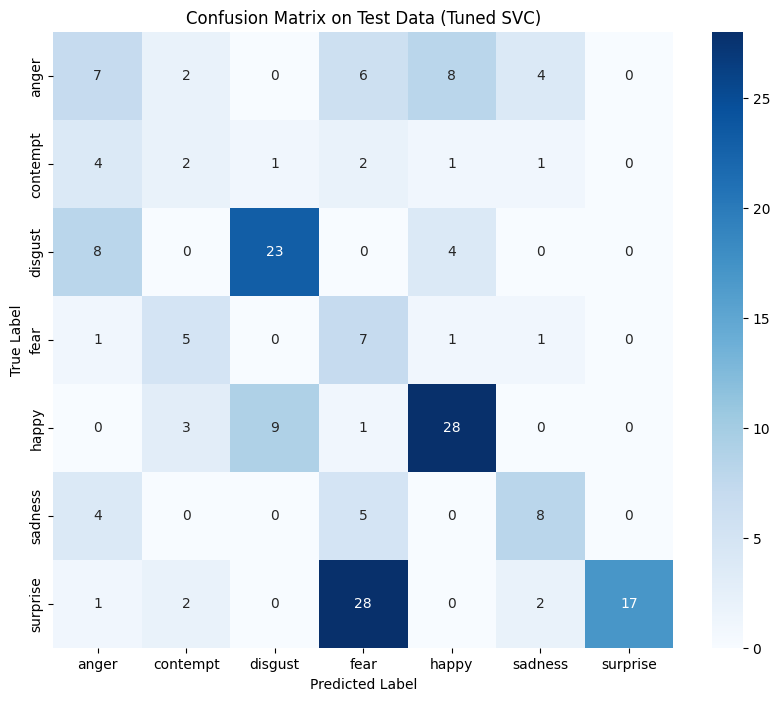


Model training and evaluation complete using valence and arousal vectors with Tuned SVC.
The model has been trained to classify emotions based purely on the calculated valence and arousal for facial parts, without seeing the actual images.


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Define the path to your generated CSV file
root_output_dir = "processed_faces_newFinal3"
csv_valence_arousal_path = os.path.join(root_output_dir, "valence_arousal_vectors.csv")

print(f"Attempting to load data from: {csv_valence_arousal_path}")

try:
    # Load the 2D valence/arousal vectors data
    df = pd.read_csv(csv_valence_arousal_path)
    print("Data loaded successfully.")
    print("DataFrame head:")
    print(df.head())
    print("\nDataFrame info:")
    df.info()

except FileNotFoundError:
    print(f"Error: The file '{csv_valence_arousal_path}' was not found.")
    print("Please ensure the previous script ran successfully and generated this CSV.")
    exit()

# --- Prepare Features (X) and Labels (y) ---
feature_columns = [col for col in df.columns if col not in ['emotion', 'filename']]
X = df[feature_columns]
y = df['emotion']

print(f"\nFeatures (X) shape: {X.shape}")
print(f"Labels (y) shape: {y.shape}")
print(f"Number of samples: {len(X)}")

if X.isnull().sum().sum() > 0:
    print("Warning: Missing values found in features. This can affect model training.")

print("\nUnique emotion labels in the dataset:")
print(y.value_counts())

# --- Split the Data into Training and Testing Sets ---
print("\nSplitting data into 80% training and 20% testing...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# --- Feature Scaling ---
print("\nScaling features using StandardScaler...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Features scaled.")

# --- Hyperparameter Tuning with GridSearchCV for SVC ---
print("\nStarting Hyperparameter Tuning for SVC using GridSearchCV...")
# Define the parameter grid to search
param_grid = {
    'C': [0.1, 1, 10, 100],            # Regularization parameter
    'gamma': ['scale', 'auto', 0.1, 1], # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
    'kernel': ['rbf']                 # Sticking with RBF kernel as it's versatile
}

# Initialize GridSearchCV
# cv=5 means 5-fold cross-validation
# verbose=3 provides more detailed output during the search
# n_jobs=-1 uses all available CPU cores for faster computation
grid_search = GridSearchCV(
    SVC(random_state=42, class_weight='balanced'), # Base SVC model
    param_grid,
    cv=5,
    verbose=2,
    n_jobs=-1,
    scoring='accuracy' # Optimize for accuracy
)

# Fit GridSearchCV on the scaled training data
grid_search.fit(X_train_scaled, y_train)

print("\nHyperparameter tuning complete.")
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation training accuracy: {grid_search.best_score_:.4f}")

# Get the best model
best_model = grid_search.best_estimator_

# --- Evaluate the Best Model on Training Data ---
print("\nEvaluating the BEST model on the TRAINING set (after tuning)...")
y_train_pred = best_model.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))

# --- Evaluate the Best Model on Testing Data ---
print("\nEvaluating the BEST model on the TEST set (after tuning)...")
y_test_pred = best_model.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))

print("\nTest Confusion Matrix:")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)



print(f"Training Accuracy: {train_accuracy:.4f}")
# ...
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# Optional: Visualize the Confusion Matrix for better understanding
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Data (Tuned SVC)')
plt.show()

print("\nModel training and evaluation complete using valence and arousal vectors with Tuned SVC.")
print("The model has been trained to classify emotions based purely on the calculated valence and arousal for facial parts, without seeing the actual images.")